In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from optbinning import Scorecard, BinningProcess, OptimalBinning

(CVXPY) Jan 26 06:04:06 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 26 06:04:06 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [5]:
dt=pd.read_csv('germancredit.csv')

In [6]:
dt["y"]=0
dt.loc[dt["creditability"]=="good",["y"]]=0
dt.loc[dt["creditability"]=="bad", ["y"]]=1
dt.drop(labels='creditability',inplace=True, axis=1)

In [7]:
dt_train, dt_test = train_test_split(dt, stratify= dt["y"], test_size=.25, random_state=1234)


In [8]:
variable="age.in.years"
X=dt_train[variable].values
Y=dt_train['y'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(X, Y)
optb.splits
binning_table = optb.binning_table
binning_table.build()

c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lro

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 25.50)    139   0.185333         81     58    0.417266   
1       [25.50, 29.50)    146   0.194667        100     46    0.315068   
2       [29.50, 34.50)    137   0.182667         94     43    0.313869   
3       [34.50, 36.50)     61   0.081333         51     10    0.163934   
4       [36.50, 38.50)     38   0.050667         30      8    0.210526   
5       [38.50, 41.50)     46   0.061333         35     11    0.239130   
6         [41.50, inf)    183   0.244000        134     49    0.267760   
7              Special      0   0.000000          0      0    0.000000   
8              Missing      0   0.000000          0      0    0.000000   
Totals                    750   1.000000        525    225    0.300000   

             WoE        IV        JS  
0      -0.513292  0.053122  0.006568  
1      -0.070769  0.000989  0.000124  
2      -0.065203  0.000787  0.000098  
3       0.781943  0.041207  0.005024  
4       0.474458  0.010242  0.001268  
5       0.310155  0.005514  0.000686  
6       0.158722  0.005946  0.000742  
7            0.0  0.000000  0.000000  
8            0.0  0.000000  0.000000  
Totals            0.117806  0.014511

In [9]:
%pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Cargar los datos desde el archivo Excel
data = pd.read_excel('DatosPractica_Scoring.xlsx')

# Análisis exploratorio inicial
print(data.info())
print(data.describe())

# Filtrar datos relevantes para clientes aceptados (Cardhldr=1) y rechazados (Cardhldr=0)
accepted_clients = data[data['Cardhldr'] == 1]
rejected_clients = data[data['Cardhldr'] == 0]

# Preprocesar los datos
# Rellenar valores nulos o eliminarlos si necesario
accepted_clients = accepted_clients.dropna()
rejected_clients = rejected_clients.dropna()

# Crear etiquetas para rechazados utilizando inferencia proporcional basada en clientes aceptados
accepted_default_rate = accepted_clients['default'].mean()
rejected_clients['default'] = np.random.binomial(1, accepted_default_rate, size=len(rejected_clients))

# Combinar aceptados y rechazados para entrenar el modelo
combined_data = pd.concat([accepted_clients, rejected_clients], ignore_index=True)

# Seleccionar las variables predictoras y la variable objetivo
X = combined_data[['Age', 'Income', 'Exp_Inc', 'Avgexp', 'Ownrent', 'Selfempl', 'Depndt', 'Inc_per', 'Cur_add', 'Major', 'Active']]
y = combined_data['default']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar un modelo de regresión logística
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Evaluar el modelo
predictions = model.predict(X_test)
proba_predictions = model.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, proba_predictions))
print(classification_report(y_test, predictions))

# Aplicar el modelo a los nuevos clientes (Cardhldr=na)
new_clients = data[data['Cardhldr'].isna()]
X_new_clients = new_clients[['Age', 'Income', 'Exp_Inc', 'Avgexp', 'Ownrent', 'Selfempl', 'Depndt', 'Inc_per', 'Cur_add', 'Major', 'Active']]

# Predecir probabilidad de impago para nuevos clientes
new_clients['Default_Probability'] = model.predict_proba(X_new_clients)[:, 1]

# Decisión de crédito: conceder crédito si la probabilidad de impago es menor a un umbral (e.g., 0.5)
new_clients['Grant_Credit'] = new_clients['Default_Probability'] < 0.5

# Filtrar los clientes a los que se concede el crédito
approved_clients = new_clients[new_clients['Grant_Credit']]

# Mostrar los IDs de los clientes aprobados
print("IDs de los clientes aprobados:", approved_clients['ID'].tolist())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        1319 non-null   int64  
 1   Cardhldr  1285 non-null   float64
 2   default   994 non-null    float64
 3   Age       1319 non-null   float64
 4   Income    1319 non-null   float64
 5   Exp_Inc   1319 non-null   float64
 6   Avgexp    1319 non-null   float64
 7   Ownrent   1319 non-null   int64  
 8   Selfempl  1319 non-null   int64  
 9   Depndt    1319 non-null   int64  
 10  Inc_per   1319 non-null   float64
 11  Cur_add   1319 non-null   int64  
 12  Major     1319 non-null   int64  
 13  Active    1319 non-null   int64  
dtypes: float64(7), int64(7)
memory usage: 144.4 KB
None
                ID     Cardhldr     default          Age       Income  \
count  1319.000000  1285.000000  994.000000  1319.000000  1319.000000   
mean    660.000000     0.773541    0.104628    33.213103     3.365

c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lrodr\AppData\Local\Temp\ipykernel_28616\867665478.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_clients['Default_Probability'] = model.predict_proba(X_new_clients)[:, 1]
C:

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\lrodr\AppData\Local\Temp\ipykernel_10052\3972816797.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.contiguity.Queen.from_dataframe(gdfm)


('WARNING: ', 816, ' is an island (no neighbors)')
('WARNING: ', 2536, ' is an island (no neighbors)')
('WARNING: ', 5326, ' is an island (no neighbors)')
('WARNING: ', 7061, ' is an island (no neighbors)')
('WARNING: ', 7160, ' is an island (no neighbors)')
('WARNING: ', 7229, ' is an island (no neighbors)')
('WARNING: ', 8106, ' is an island (no neighbors)')
('WARNING: ', 8107, ' is an island (no neighbors)')


c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  W.__init__(self, neighbors, ids=ids, **kw)


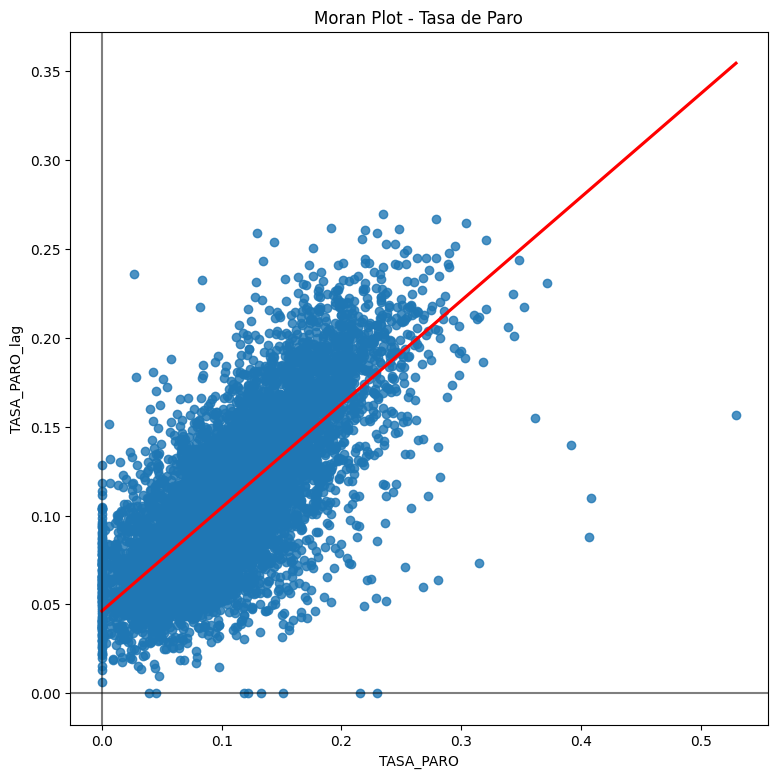

np.float64(0.5837735296544684)

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install pysal
from pysal.lib import weights
from pysal.explore import esda


gdfm =gpd.read_file("cartografias/Munic04_ESP.shp")

wq = weights.contiguity.Queen.from_dataframe(gdfm)
wq.transform = "R"

gdfm["TASA_PARO_lag"] = weights.spatial_lag.lag_spatial(wq, gdfm["TASA_PARO"])


f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(
    x="TASA_PARO",
    y="TASA_PARO_lag",
    ci=None,
    data=gdfm,
    line_kws={"color": "r"})
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Tasa de Paro")
plt.show()



moran = esda.moran.Moran(gdfm["TASA_PARO"], wq)
moran.I

In [19]:
moran.p_sim

np.float64(0.001)

In [20]:
import pandas as pd
import geopandas as gpd
from pysal.lib import weights
from pysal.explore import esda
import numpy as np

# Leer el archivo CSV
df = pd.read_csv('Data_Housing_Madrid.csv')

# Crear un GeoDataFrame con las coordenadas geográficas
gdfm = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude), 
    crs='EPSG:4326'
)

# Filtrar las viviendas del centro histórico
gdfm_historical = gdfm[gdfm["historical"] == 1]

# Construir una matriz de pesos espaciales híbrida (DistanceBand)
# Umbral: 250 metros (0.00225 grados)
w_hy = weights.distance.DistanceBand.from_dataframe(
    gdfm_historical, threshold=0.00225, alpha=-1, binary=False
)

# Calcular la I de Moran para house.price en el centro histórico
moran = esda.moran.Moran(gdfm_historical["house.price"], w_hy)

# Preguntas solicitadas
# 1. Número total de viviendas
total_viviendas = len(gdfm)

# 2. Número de viviendas en el centro histórico
viviendas_historico = len(gdfm_historical)

# 3. Precio mediano de las viviendas en el centro histórico
precio_median_historico = gdfm_historical["house.price"].median()

# 4. Precio máximo de las viviendas en el centro histórico
precio_max_historico = gdfm_historical["house.price"].max()

# 5. Número de viviendas sin vecinas próximas
viviendas_sin_vecinas = sum([1 for i in w_hy.neighbors if len(w_hy.neighbors[i]) == 0])

# 6. Número mediano de viviendas próximas
mediana_vecinas = np.median([len(neighbors) for neighbors in w_hy.neighbors.values()])

# 7. Valor de la I de Moran
moran_i = round(moran.I, 3)

# 8. P-valor del contraste de ausencia de autocorrelación espacial global
p_valor = round(moran.p_sim, 3)

# Imprimir resultados
print("Número total de viviendas:", total_viviendas)
print("Número de viviendas en el centro histórico:", viviendas_historico)
print("Precio mediano de las viviendas en el centro histórico:", precio_median_historico)
print("Precio máximo de las viviendas en el centro histórico:", precio_max_historico)
print("Número de viviendas sin vecinas próximas:", viviendas_sin_vecinas)
print("Número mediano de viviendas próximas:", mediana_vecinas)
print("I de Moran:", moran_i)
print("P-valor del test de Moran:", p_valor)

# Interpretación final
if moran.p_sim < 0.05:
    print("Analizar el precio de las viviendas vecinas SÍ ayuda a estimar el precio de una vivienda en el centro histórico de Madrid.")
else:
    print("Analizar el precio de las viviendas vecinas NO ayuda a estimar el precio de una vivienda en el centro histórico de Madrid.")


c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 140 disconnected components.
 There are 106 islands with ids: 20, 88, 279, 299, 363, 377, 430, 705, 826, 866, 923, 932, 1062, 1119, 1150, 1190, 1232, 1255, 1298, 1432, 1537, 1582, 1758, 2041, 2078, 2095, 2102, 2370, 2429, 2601, 2716, 3028, 3076, 3244, 3298, 3411, 3437, 3615, 3694, 3726, 3830, 4100, 4124, 4188, 4193, 4228, 4279, 4408, 4681, 4726, 4735, 4775, 4828, 4845, 5011, 5404, 5423, 5441, 5469, 5847, 6008, 6019, 6046, 6124, 6279, 6313, 6489, 6535, 6961, 6993, 7186, 7215, 7366, 7538, 7693, 7803, 7841, 7914, 7942, 8080, 8220, 8241, 8674, 8694, 8823, 8916, 8950, 9140, 9171, 9267, 9458, 9617, 9695, 9771, 9790, 9866, 9934, 9939, 10019, 10035, 10092, 10242, 10256, 10286, 10435, 10480.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\L

('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 88, ' is an island (no neighbors)')
('WARNING: ', 279, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 363, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 430, ' is an island (no neighbors)')
('WARNING: ', 705, ' is an island (no neighbors)')
('WARNING: ', 826, ' is an island (no neighbors)')
('WARNING: ', 866, ' is an island (no neighbors)')
('WARNING: ', 923, ' is an island (no neighbors)')
('WARNING: ', 932, ' is an island (no neighbors)')
('WARNING: ', 1062, ' is an island (no neighbors)')
('WARNING: ', 1119, ' is an island (no neighbors)')
('WARNING: ', 1150, ' is an island (no neighbors)')
('WARNING: ', 1190, ' is an island (no neighbors)')
('WARNING: ', 1232, ' is an island (no neighbors)')
('WARNING: ', 1255, ' is an island (no neighbors)')
('WARNING: ', 1298, ' is an island (no neighbors)')
('WARNING: ', 1432, ' is a

In [1]:
import geopandas as gpd

gdfm =gpd.read_file("cartografias/Munic04_ESP.shp") 
gdfm_Madrid =gdfm[gdfm['COD_PROV']=='28']

gdfm_Madrid.explore(column='PrecioIn16', 
                    scheme='NaturalBreaks',
                    k=9, cmap='YlOrRd',
                    legend=False,
                    style_kwds=dict(fillOpacity=0.8))

C:\Users\lrodr\AppData\Local\Temp\ipykernel_28616\3540486390.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.contiguity.Queen.from_dataframe(gdfm)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  W.__init__(self, neighbors, ids=ids, **kw)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\weights.py:1484: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid
c:\Users\lrodr\OneDrive\D

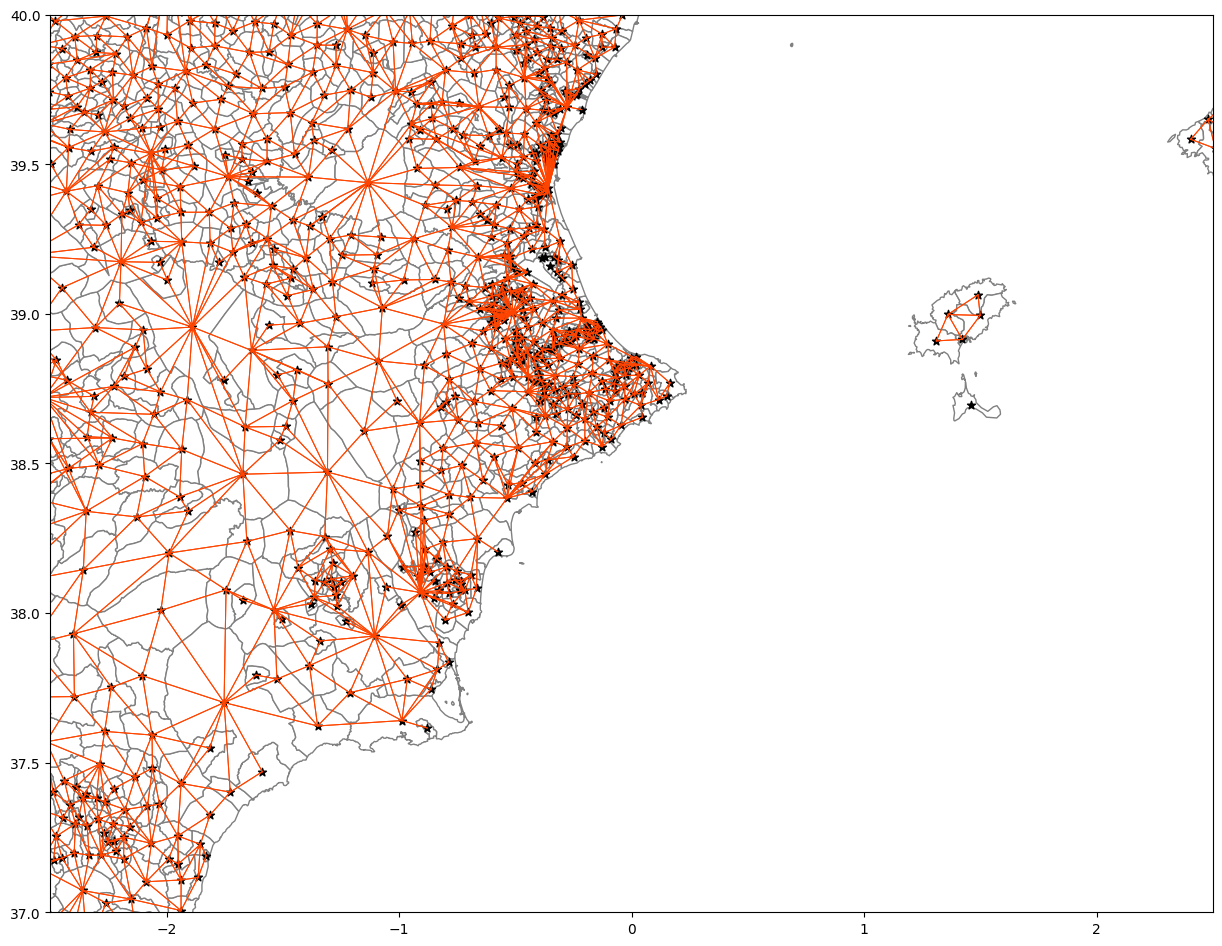

In [2]:
import matplotlib.pyplot as plt
from pysal.lib import weights


gdfm =gpd.read_file("cartografias/Munic04_ESP.shp")

wq = weights.contiguity.Queen.from_dataframe(gdfm)

ax = gdfm.plot(
        edgecolor="grey", facecolor="w",
        figsize=(15,15))

plt.xlim(-2.5,2.5)
plt.ylim(37,40)

wq.plot(
    gdfm,
    edge_kws=dict(linewidth=0.75, color="orangered"),
    node_kws=dict(marker="*"),
    ax=ax)
plt.show()

2.5
2.5
2.5


c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lrodr\AppData\Local\Temp\ipykernel_28616\3347781842.py:10: FutureWarning: `use_index`

('WARNING: ', 816, ' is an island (no neighbors)')
('WARNING: ', 2536, ' is an island (no neighbors)')
('WARNING: ', 5326, ' is an island (no neighbors)')
('WARNING: ', 7061, ' is an island (no neighbors)')
('WARNING: ', 7160, ' is an island (no neighbors)')
('WARNING: ', 7229, ' is an island (no neighbors)')
('WARNING: ', 8106, ' is an island (no neighbors)')
('WARNING: ', 8107, ' is an island (no neighbors)')


c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  W.__init__(self, neighbors, ids=ids, **kw)


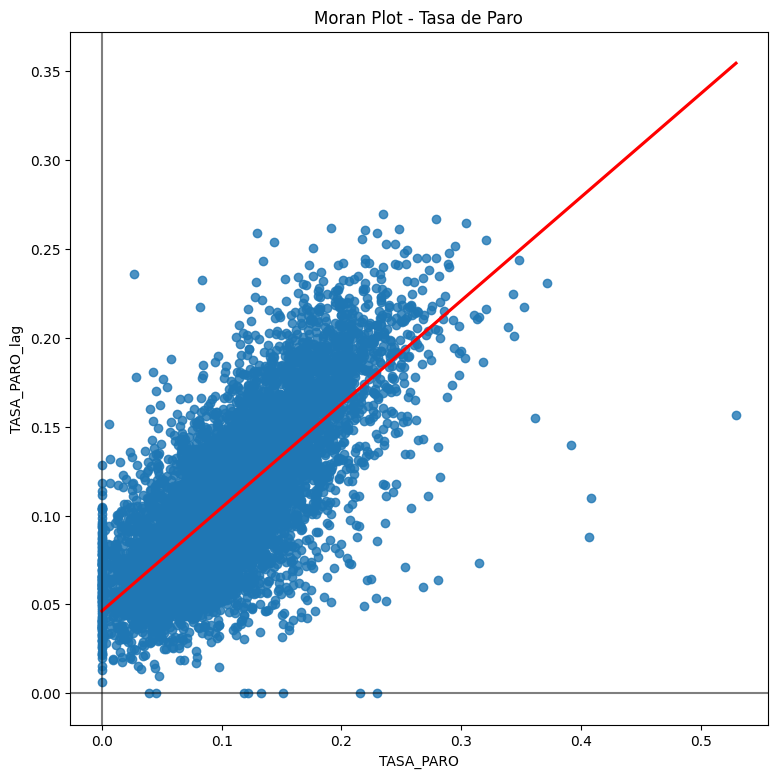

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.lib import weights
from pysal.explore import esda


gdfm =gpd.read_file("cartografias/Munic04_ESP.shp")

wq = weights.contiguity.Queen.from_dataframe(gdfm)
wq.transform = "R"

gdfm["TASA_PARO_lag"] = weights.spatial_lag.lag_spatial(wq, gdfm["TASA_PARO"])


f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(
    x="TASA_PARO",
    y="TASA_PARO_lag",
    ci=None,
    data=gdfm,
    line_kws={"color": "r"})
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Tasa de Paro")
plt.show()

In [4]:
moran = esda.moran.Moran(gdfm["TASA_PARO"], wq)

In [6]:
print("I de Moran:", moran.I)           # El valor de I de Moran
print("p-valor:", moran.p_sim)          # El p-valor asociado al test
print("z-score:", moran.z_sim)          # El estadístico Z para la significancia
print("Número de permutaciones:", moran.permutations)  # Número de permutaciones

I de Moran: 0.5837735296544684
p-valor: 0.001
z-score: 86.93682455135367
Número de permutaciones: 999


In [7]:
from pysal.model import spreg

gdfm =gpd.read_file("cartografias/Munic04_ESP.shp")

wq = weights.contiguity.Queen.from_dataframe(gdfm)
wq.transform = "R"



# MODELO (A)

modelo_A = spreg.OLS(
    # Dependent variable
    gdfm[["TASA_PARO"]].values,
    # Independent variables
    gdfm[["RENTPCAP07"]].values,
    # Dependent variable name
    name_y="TASA_PARO",
    # Independent variable name
    name_x=["RENTA_PERCAPITA"])

gdfm["residual"] = modelo_A.u

moran = esda.moran.Moran(gdfm["residual"], wq)
print("I de moran:", moran.I.round(3))
print("p-valor:", moran.p_sim)


# MODELO (B)

modelo_B = spreg.GM_Error_Het(
    # Dependent variable
    gdfm[["TASA_PARO"]].values,
    # Independent variables
    gdfm[["RENTPCAP07"]].values,
    # Spatial weights matrix
    w=wq,
    # Dependent variable name
    name_y="TASA_PARO",
    # Independent variable name
    name_x=["RENTA_PERCAPITA"])  
  
gdfm["mLagresidual"] = modelo_B.e_filtered

moran = esda.moran.Moran(gdfm["mLagresidual"], wq)
print("I de moran:", moran.I.round(3))
print("p-valor:", moran.p_sim)


C:\Users\lrodr\AppData\Local\Temp\ipykernel_28616\2747160085.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = weights.contiguity.Queen.from_dataframe(gdfm)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 816, ' is an island (no neighbors)')
('WARNING: ', 2536, ' is an island (no neighbors)')
('WARNING: ', 5326, ' is an island (no neighbors)')
('WARNING: ', 7061, ' is an island (no neighbors)')
('WARNING: ', 7160, ' is an island (no neighbors)')
('WARNING: ', 7229, ' is an island (no neighbors)')
('WARNING: ', 8106, ' is an island (no neighbors)')
('WARNING: ', 8107, ' is an island (no neighbors)')
I de moran: 0.581
p-valor: 0.001
I de moran: -0.066
p-valor: 0.001


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('datos/Data_Housing_Madrid.csv')  

gdfm = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326') 

In [14]:
# Filtrar solo las viviendas del centro histórico
gdfm_historical = gdfm[gdfm['historical'] == 1]  # Asumiendo que 1 significa que es del casco histórico

w_hy = weights.distance.DistanceBand.from_dataframe(
    gdfm_historical, threshold = 0.00225, alpha=-1, binary=False) 

c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 140 disconnected components.
 There are 106 islands with ids: 20, 88, 279, 299, 363, 377, 430, 705, 826, 866, 923, 932, 1062, 1119, 1150, 1190, 1232, 1255, 1298, 1432, 1537, 1582, 1758, 2041, 2078, 2095, 2102, 2370, 2429, 2601, 2716, 3028, 3076, 3244, 3298, 3411, 3437, 3615, 3694, 3726, 3830, 4100, 4124, 4188, 4193, 4228, 4279, 4408, 4681, 4726, 4735, 4775, 4828, 4845, 5011, 5404, 5423, 5441, 5469, 5847, 6008, 6019, 6046, 6124, 6279, 6313, 6489, 6535, 6961, 6993, 7186, 7215, 7366, 7538, 7693, 7803, 7841, 7914, 7942, 8080, 8220, 8241, 8674, 8694, 8823, 8916, 8950, 9140, 9171, 9267, 9458, 9617, 9695, 9771, 9790, 9866, 9934, 9939, 10019, 10035, 10092, 10242, 10256, 10286, 10435, 10480.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\lrodr\OneDrive\Documentos\master_ucm\trabajos\8.0\entornoScoring\L

In [15]:
# Número total de viviendas
total_viviendas = len(df)
print(f"Número total de viviendas: {total_viviendas}")

Número total de viviendas: 10512


In [16]:
# Número de viviendas en el casco histórico
total_historical = len(gdfm_historical)
print(f"Número de viviendas en el casco histórico: {total_historical}")


Número de viviendas en el casco histórico: 3633


In [17]:
# Precio mediano de las viviendas en el casco histórico
precio_mediano_historical = gdfm_historical['house.price'].median()
print(f"Precio mediano de las viviendas en el casco histórico: {precio_mediano_historical}")


Precio mediano de las viviendas en el casco histórico: 4444.0


In [18]:
# Precio máximo de las viviendas en el casco histórico
precio_maximo_historical = gdfm_historical['house.price'].max()
print(f"Precio máximo de las viviendas en el casco histórico: {precio_maximo_historical}")


Precio máximo de las viviendas en el casco histórico: 20131.0


In [26]:
# Número de viviendas sin vecinas próximas
no_vecinas_proximas = sum(1 for neighbors in w_hy.neighbors.values() if len(neighbors) == 0)
print(f"Número de viviendas sin vecinas próximas: {no_vecinas_proximas}")

# Número mediano de viviendas vecinas para cada vivienda
numero_vecinas = [len(neighbors) for neighbors in w_hy.neighbors.values() if neighbors]
numero_vecinas_mediano = pd.Series(numero_vecinas).median()
print(f"Número mediano de viviendas vecinas: {numero_vecinas_mediano}")


Número de viviendas sin vecinas próximas: 106
Número mediano de viviendas vecinas: 21.0


In [21]:
from esda.moran import Moran
import numpy as np

# Calcular el índice de Moran de los precios de las viviendas en el casco histórico
moran = Moran(gdfm_historical['house.price'].values, w_hy)

# Valor de la I de Moran
I_moran = moran.I
print(f"Índice de Moran: {round(I_moran, 3)}")

# P-valor del contraste de autocorrelación espacial
p_value = moran.p_sim
print(f"P-valor de Moran: {round(p_value, 3)}")


('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 88, ' is an island (no neighbors)')
('WARNING: ', 279, ' is an island (no neighbors)')
('WARNING: ', 299, ' is an island (no neighbors)')
('WARNING: ', 363, ' is an island (no neighbors)')
('WARNING: ', 377, ' is an island (no neighbors)')
('WARNING: ', 430, ' is an island (no neighbors)')
('WARNING: ', 705, ' is an island (no neighbors)')
('WARNING: ', 826, ' is an island (no neighbors)')
('WARNING: ', 866, ' is an island (no neighbors)')
('WARNING: ', 923, ' is an island (no neighbors)')
('WARNING: ', 932, ' is an island (no neighbors)')
('WARNING: ', 1062, ' is an island (no neighbors)')
('WARNING: ', 1119, ' is an island (no neighbors)')
('WARNING: ', 1150, ' is an island (no neighbors)')
('WARNING: ', 1190, ' is an island (no neighbors)')
('WARNING: ', 1232, ' is an island (no neighbors)')
('WARNING: ', 1255, ' is an island (no neighbors)')
('WARNING: ', 1298, ' is an island (no neighbors)')
('WARNING: ', 1432, ' is a

In [22]:
if p_value < 0.05:
    if I_moran > 0:
        print("Según estos resultados, analizar el precio de las viviendas vecinas sí ayuda a estimar el precio de una vivienda en el centro histórico de Madrid.")
    else:
        print("Según estos resultados, no es posible determinar si el precio de las viviendas vecinas ayudan o no ayudan a estimar el precio de una vivienda en el centro histórico de Madrid.")
else:
    print("Según estos resultados, analizar el precio de las viviendas vecinas NO ayuda a estimar el precio de una vivienda en el centro histórico de Madrid.")


Según estos resultados, analizar el precio de las viviendas vecinas sí ayuda a estimar el precio de una vivienda en el centro histórico de Madrid.
